In [66]:
%load_ext autoreload
#always reload modules so that as you change code, it gets loaded
%autoreload 2
#%aimport rl # make sure you call once: pip install -e . 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rl.simulations import parallel as para
from rl.bandits import simulations_decorators
from rl.bandits import k_arms_reward_creator
from rl.bandits import greedy_exploration, greedy_upper_confidence_bound, gradient_bandit
np.random.seed(42)
plt.rcParams['figure.figsize'] = (11,4)
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
arms = 10
q_stars, bandits = k_arms_reward_creator(k=arms)

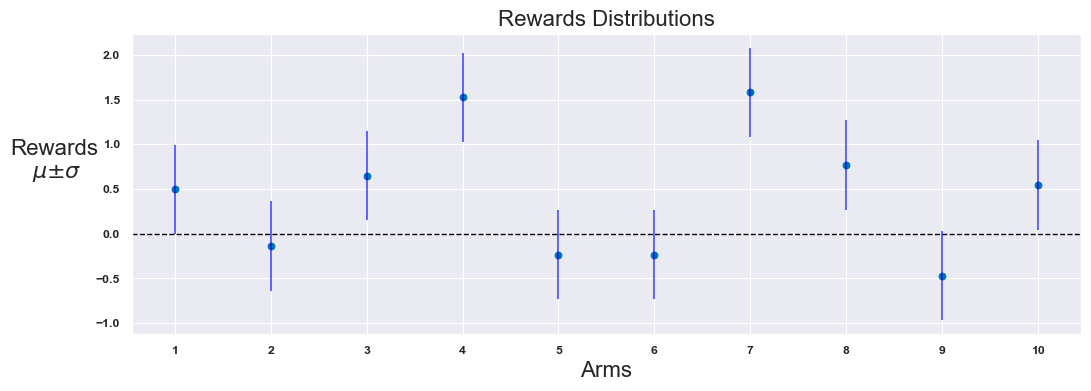

In [67]:
ig, ax1 = plt.subplots(1,1)
ax1.scatter(range(1,arms+1), q_stars)

ax1.axhline(0, color='black', lw=1, linestyle='--')
for i in range(arms):
   ax1.vlines(x=i+1,
              ymin=q_stars[i]-.5,
              ymax=q_stars[i]+.5,
              alpha=.7,
              color='blue') 
ax1.set_xlabel("Arms", fontsize=16)
ax1.set_xticks(range(1, arms+1))
ax1.set_ylabel("Rewards\n $\mu±\sigma$", fontsize=16, rotation=0)
ax1.yaxis.labelpad = 30
plt.title("Rewards Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [69]:
Qs, stats = greedy_exploration(arms, bandits, epsilon=0.1, max_try=10000)
print('q_stars:\t',q_stars)
print('Estimated Qs:\t',Qs)
print('rewards:', np.sum(stats['rewards']))
print('Ns:', stats['Ns'])
print('Actions:', stats['actions'])

q_stars:	 [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
Estimated Qs:	 [ 0.53256025  0.11102116  0.73153318  1.48060771 -0.32293164 -0.19493835
  1.57673466  0.77055629 -0.66080336  0.59855016]
rewards: 14638.134063953756
Ns: [ 106.  105.   94.   96.   97.   93. 9085.  122.  104.   98.]
Actions: [0. 1. 7. ... 3. 6. 6.]


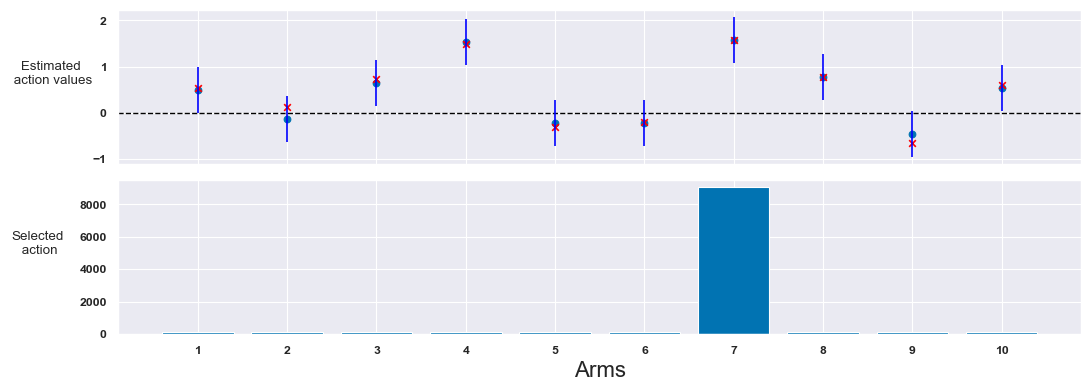

In [73]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
arms_list = range(1,arms+1)
ax1.scatter(arms_list, q_stars)
ax1.axhline(0, color='black', lw=1, linestyle='--')
for i in range(arms):
   ax1.vlines(x=i+1, ymin=q_stars[i]-.5, ymax=q_stars[i]+.5, color='blue') 

ax1.scatter(arms_list, Qs, color='red', marker='x')
ax1.set_xticks(arms_list)
ax1.set_ylabel("Estimated\n action values", rotation=0)
ax1.yaxis.labelpad = 30

ax2.bar(arms_list,stats['Ns'])
ax2.set_xticks(arms_list)
ax2.set_xlabel("Arms", fontsize=16)
ax2.set_ylabel("Selected\n action", rotation=0)
ax2.yaxis.labelpad = 30
plt.tight_layout();plt.show()

# Comparing greedy search vs exploration/exploitation

In [74]:
rewards_per_epsilon = []
actions_per_epsilon = []
epsilons = [0, 0.01, .1]
simulation_steps_length = 1000
para_2 = simulations_decorators(para)

for epsilon in epsilons:
    Qs, stats = para_2(greedy_exploration,
                      simulations = 2000,
                      concurrent = 25,
                      func_uniqe_index = False,
                      func_args = (arms, bandits, epsilon, simulation_steps_length))
              
    rewards_per_epsilon.append(stats['rewards'])
    actions_per_epsilon.append(stats['actions'])

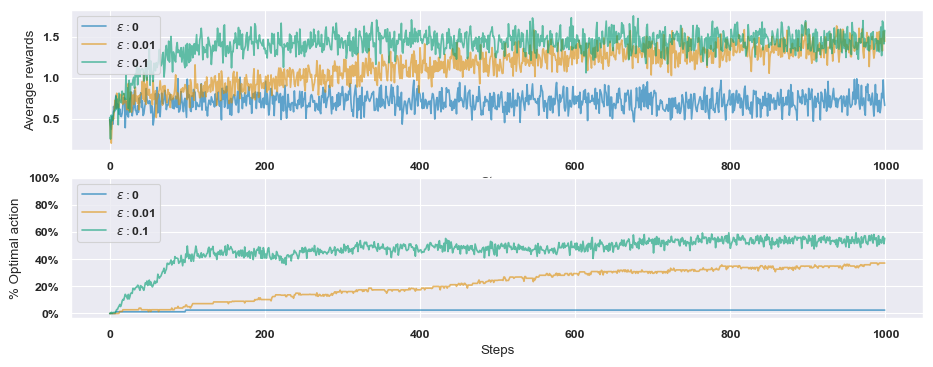

In [75]:
fig, (ax1, ax2) = plt.subplots(2,1)
for rewards, epsilon in zip(rewards_per_epsilon, epsilons):
    ax1.plot(rewards.mean(axis=0), label=f"$\epsilon:${epsilon}", alpha=.6)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average rewards')
ax1.legend()

optimal_action = np.argmax(q_stars)
for actions, epsilon in zip(actions_per_epsilon, epsilons):
    ax2.plot((actions == optimal_action).mean(axis=0), 
             label=f"$\epsilon:${epsilon}", alpha=.6)
ax2.set_xlabel('Steps')
ax2.set_ylabel('% Optimal action')
ax2.set_yticks(np.arange(0, 1.1, .2))
ax2.set_yticklabels([str(int(i))+"%" for i in np.arange(0, 110, 20)])
ax2.legend()
plt.show()

# Optimistic Initial Values

In [76]:
actions_per_epsilon = []
epsilons = [0, .1]
init_Qs = [5, 0]
simulation_steps_length = 1000
para_2 = simulations_decorators(para)

for epsilon, init_Q in zip(epsilons, init_Qs):
    Qs, stats = para_2(greedy_exploration,
                      simulations = 2000,
                      concurrent = 25,
                      func_uniqe_index = False,
                      func_args = (arms, bandits, epsilon, simulation_steps_length, init_Q))
              
    actions_per_epsilon.append(stats['actions'])

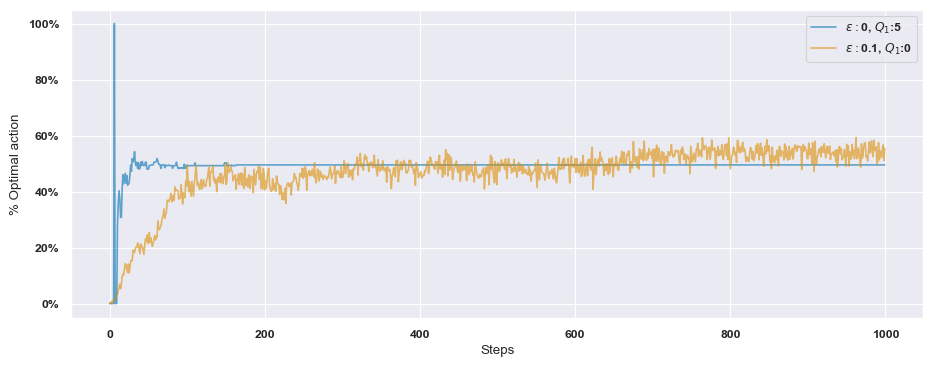

In [78]:
fig, ax = plt.subplots(1,1)
optimal_action = np.argmax(q_stars)
for actions, epsilon, init_Q in zip(actions_per_epsilon, epsilons, init_Qs):
    ax.plot((actions == optimal_action).mean(axis=0), 
             label=f"$\epsilon:${epsilon}, $Q_1$:{init_Q}", alpha=.6)
ax.set_xlabel('Steps')
ax.set_ylabel('% Optimal action')
ax.set_yticks(np.arange(0, 1.1, .2))
ax.set_yticklabels([str(int(i))+"%" for i in np.arange(0, 110, 20)])
ax.legend()
plt.show()

# Upper-Confidence-Bound

In [79]:
rewards_per_algorithms = []

simulation_steps_length = 1000
para_2 = simulations_decorators(para)
epsilon=0.1
c = 2.0

Qs, stats = para_2(greedy_exploration,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, epsilon, simulation_steps_length))
            
rewards_per_algorithms.append(stats['rewards'])

Qs, stats = para_2(greedy_upper_confidence_bound,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, c, simulation_steps_length))
            
rewards_per_algorithms.append(stats['rewards'])

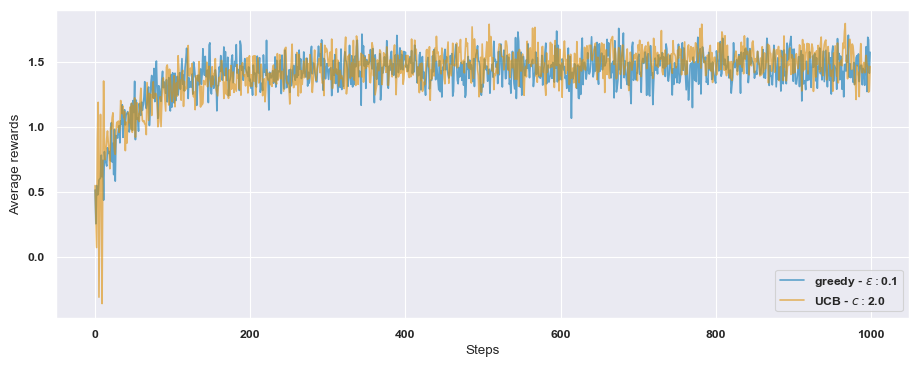

In [80]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(rewards_per_algorithms[0].mean(axis=0), 
         label=f"greedy - $\epsilon:${epsilon}", alpha=.6)
ax1.plot(rewards_per_algorithms[1].mean(axis=0), 
         label=f"UCB - $c:${c}", alpha=.6)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average rewards')
ax1.legend()
plt.show()

# Gradient Bandit Algorithm

In [81]:
rewards_per_algorithms = []

simulation_steps_length = 1000
para_2 = simulations_decorators(para)
epsilon = 0.1
alpha = 0.1

Qs, stats = para_2(greedy_exploration,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, epsilon, simulation_steps_length))
            
rewards_per_algorithms.append(stats['rewards'])

Qs, stats = para_2(gradient_bandit,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, epsilon, alpha, simulation_steps_length))
            
rewards_per_algorithms.append(stats['rewards'])

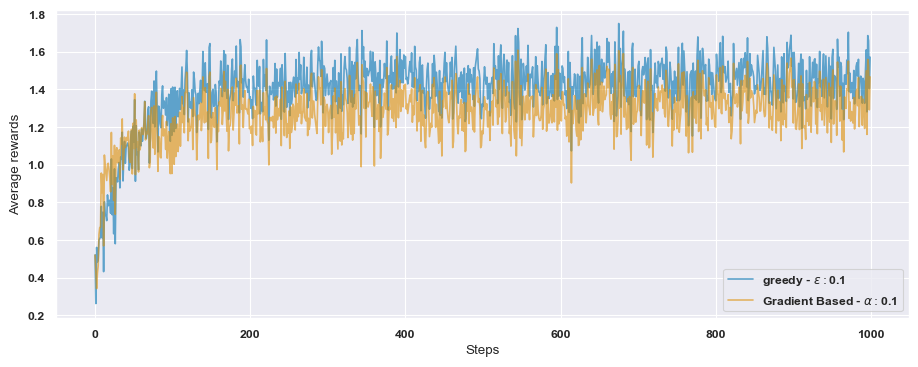

In [82]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(rewards_per_algorithms[0].mean(axis=0), 
         label=f"greedy - $\epsilon:${epsilon}", alpha=.6)
ax1.plot(rewards_per_algorithms[1].mean(axis=0), 
         label=r"Gradient Based - $\alpha:$"f"{alpha}", alpha=.6)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average rewards')
ax1.legend()
plt.show()

## Gradient Bandit Algorithm: alpha effects 

In [83]:
rewards_per_alphas = []

simulation_steps_length = 1000
para_2 = simulations_decorators(para)
epsilon = 0.1
alphas = [0.01, 0.1, 0.5, .9]

for alpha in alphas:
    Qs, stats = para_2(gradient_bandit,
                    simulations = 2000,
                    concurrent = 25,
                    func_uniqe_index = False,
                    func_args = (arms, bandits, epsilon, alpha, simulation_steps_length))
            
    rewards_per_alphas.append(stats['rewards'])

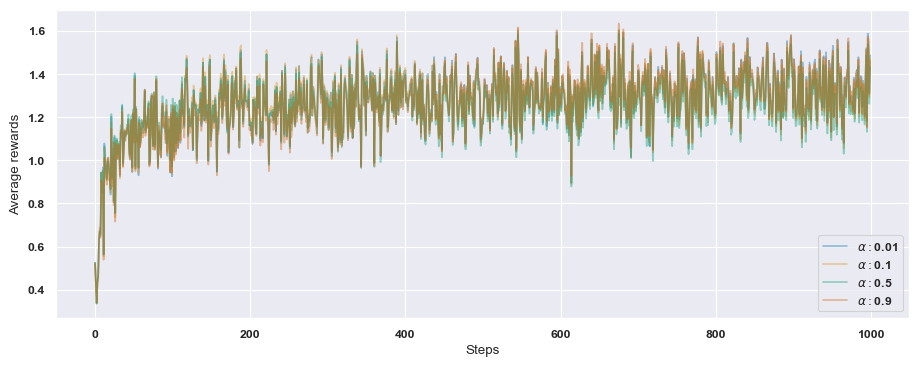

In [88]:
fig, ax = plt.subplots(1,1)
for rewards, alpha in zip(rewards_per_alphas, alphas):
    ax.plot(rewards.mean(axis=0), label=r"$\alpha:$"f"{alpha}", alpha=.4)
ax.set_xlabel('Steps')
ax.set_ylabel('Average rewards')
ax.legend()
plt.show()